## Table of Contents
* Setting up the environment with the necessary libraries and tools.
* Reading in the dataset
*	Data Inspection
* Exploratory Data Analysis and Market Insights
*	Volatility Analysis
*	Data Merging
* Target Feature Definition
*	Implementation of Models
*	Evaluation of Models
*	Esembling of Models









Task 1:

## Setting up the environment with the necessary libraries and tools

In [1]:
# Import required utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    roc_curve,
    auc,
    precision_recall_fscore_support,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

In [ ]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

In [3]:
# Import the dataset
trades = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/trades.csv')

In [4]:
# snapshot of the data
trades.head(n = 5)

,pair,amount,volume,side,timestamp,user_id
0,AAVENGN,500.26,0.001222,buy,2024-12-03T01:42:07.072672Z,541-1561-1521-1561-148
1,ADANGN,889.20,0.500000,sell,2024-12-02T11:29:56.860014Z,491-1541-1521-1571-156
2,ADANGN,30653.12,17.100000,sell,2024-11-30T05:25:49.99166Z,1021-1481-1521-1561-1100
3,ADANGN,1978.36,1.100000,sell,2024-12-07T07:41:02.191598Z,981-1571-1521-1971-151
4,ADANGN,2913.62,1.600000,sell,2024-12-07T21:16:11.791118Z,981-1571-1521-1971-151


In [5]:
# checking the data types
trades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pair       2324 non-null   object 
 1   amount     2324 non-null   float64
 2   volume     2324 non-null   float64
 3   side       2324 non-null   object 
 4   timestamp  2324 non-null   object 
 5   user_id    2324 non-null   object 
dtypes: float64(2), object(4)
memory usage: 109.1+ KB


In [6]:
# Convert features to have the right datatypes
for column in trades.select_dtypes(include = ["object"]):
    try:
        data[column] = data[column].values.astype("int")
    except:
        pass

In [7]:
# checking the data types again
trades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pair       2324 non-null   object 
 1   amount     2324 non-null   float64
 2   volume     2324 non-null   float64
 3   side       2324 non-null   object 
 4   timestamp  2324 non-null   object 
 5   user_id    2324 non-null   object 
dtypes: float64(2), object(4)
memory usage: 109.1+ KB


### Cardinality

In [8]:
# Feature cardinality
trades.nunique()

,0
pair,50
amount,2286
volume,1975
side,2
timestamp,2324
user_id,1199


In [9]:
# checking the data shape
trades.shape

(2324, 6)

## Data Summary

In [10]:
# Finding the summary statistics of the numerical variables and making the display natural and not scientific
pd.set_option('display.float_format', '{:,.2f}'.format)
trades[['volume', 'amount']].describe()

,volume,amount
count,"2,324.00","2,324.00"
mean,"34,115.97","148,817.27"
std,"1,102,013.91","472,912.56"
min,0.00,0.02
25%,0.00,"9,897.79"
50%,0.01,"29,998.06"
75%,13.72,"98,765.19"
max,"51,754,382.05","9,209,866.51"


In [11]:
# testing for the coefficient of skewness for both datapoints
print(trades['volume'].skew())
print(trades['amount'].skew())

44.845018777736115
8.884439099431098


In [12]:
# Missing Values
# Check for missing values as percentages
missing_values = 100 * trades.isnull().sum() / len(trades)
print(missing_values)

pair        0.00
amount      0.00
volume      0.00
side        0.00
timestamp   0.00
user_id     0.00
dtype: float64


# Exploratory Data Analysis and Market Insights

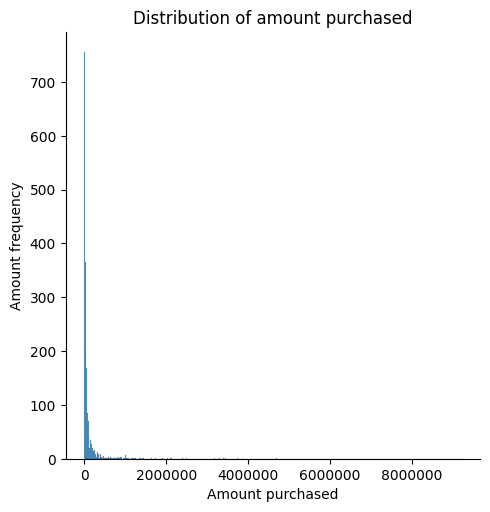

In [13]:
# Distribution of amount purchased
sns.displot(trades["amount"])
plt.ticklabel_format(style='plain', axis='x')   # <-- turn off scientific notation on x-axis
plt.title("Distribution of amount purchased")
plt.xlabel("Amount purchased")
plt.ylabel("Amount frequency")
plt.show()
plt.close("all")

In [14]:
# Plotting an interactive plot to better showcase the distribution of amount purchased
import plotly.express as px

fig = px.histogram(trades, x="amount",
                   title="Distribution of amount purchased",
                   labels={"amount": "Amount purchased"},
                   nbins=50)  # adjust bins if needed
fig.update_xaxes(tickformat="," )  # no scientific notation
fig.update_yaxes(title_text="Amount frequency")
fig.show()

In [15]:
# converting the timestamps
trades['timestamp'] = pd.to_datetime(trades['timestamp'])

In [16]:
# Group and get top 3 pairs
pair_volumes = trades.groupby('pair')['amount'].sum().sort_values(ascending=False)
top3_pairs = pair_volumes.head(3)

In [17]:
print("Top 3 Trading Pairs by Volume:")
print(top3_pairs)

Top 3 Trading Pairs by Volume:
pair
BTCNGN    204,323,233.02
USDTNGN    88,770,860.37
ETHNGN     14,646,884.27
Name: amount, dtype: float64


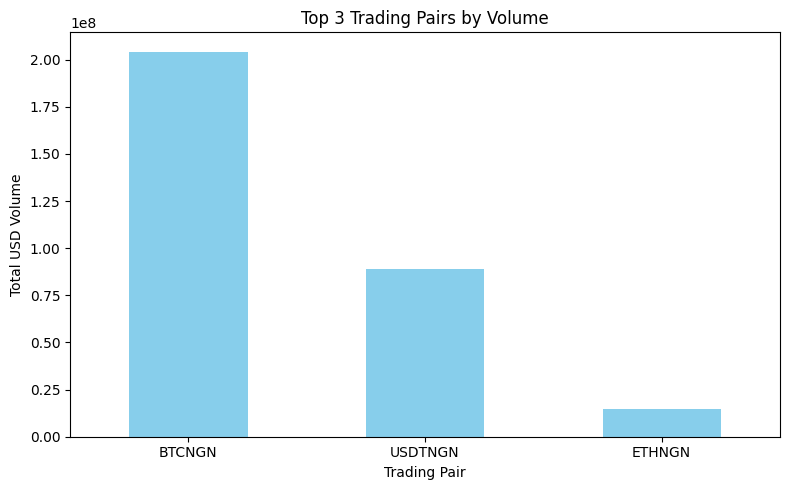

In [18]:
# Visualization
plt.figure(figsize=(8,5))
top3_pairs.plot(kind='bar', color='skyblue')
plt.title("Top 3 Trading Pairs by Volume")
plt.ylabel("Total USD Volume")
plt.xlabel("Trading Pair")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Volatility Analysis

In [19]:
# Filter BTCNGN trades and calculate price
btc_trades = trades[trades['pair'] == 'BTCNGN'].copy()
btc_trades['price'] = btc_trades['amount'] / btc_trades['volume']
btc_trades['date'] = btc_trades['timestamp'].dt.date

In [20]:
# Calculate daily volatility
daily_stats = btc_trades.groupby('date')['price'].agg(['max','min','mean'])
daily_stats['volatility'] = (daily_stats['max'] - daily_stats['min']) / daily_stats['mean']

In [21]:
# 7-day rolling average
daily_stats['volatility_7d'] = daily_stats['volatility'].rolling(window=7).mean()

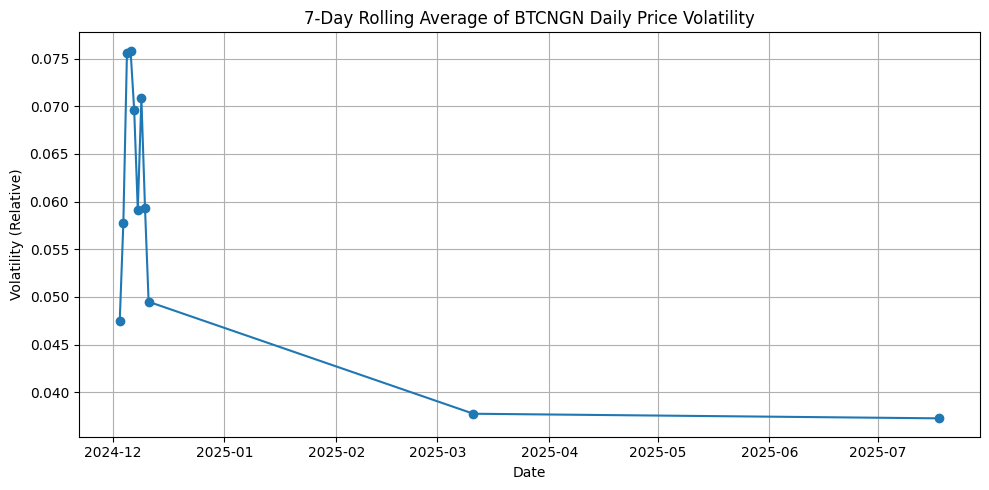

In [22]:
# Plot
plt.figure(figsize=(10,5))
plt.plot(daily_stats.index, daily_stats['volatility_7d'], marker='o')
plt.title("7-Day Rolling Average of BTCNGN Daily Price Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility (Relative)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
user_activity = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fraud Detection/user_activitycsv.csv")

In [24]:
# converting the timestamps
user_activity['timestamp'] = pd.to_datetime(user_activity['timestamp'])

In [25]:
# Filter deposits only
deposits = user_activity[user_activity['activity_type'] == 'deposit'].copy()
deposits['day_of_week'] = deposits['timestamp'].dt.day_name()
deposits['hour'] = deposits['timestamp'].dt.hour

In [26]:
# Count by day and hour
day_counts = deposits.groupby('day_of_week').size().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)
hour_counts = deposits.groupby('hour').size()

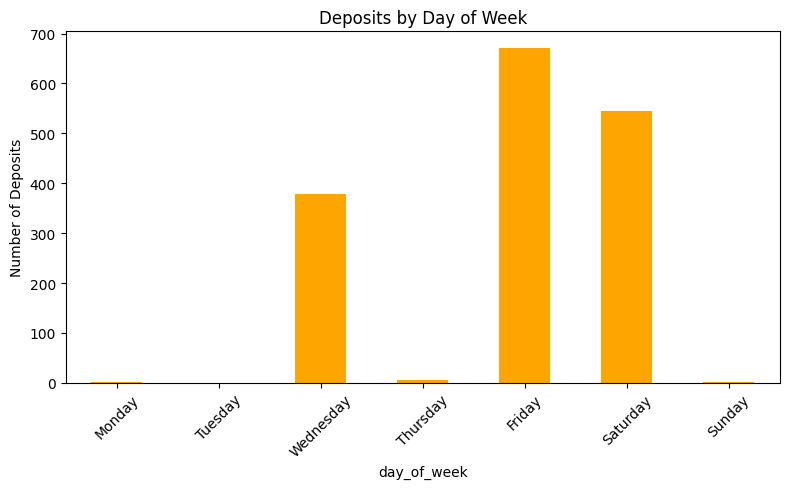

In [27]:
# Plot deposits by day
plt.figure(figsize=(8,5))
day_counts.plot(kind='bar', color='orange')
plt.title("Deposits by Day of Week")
plt.ylabel("Number of Deposits")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

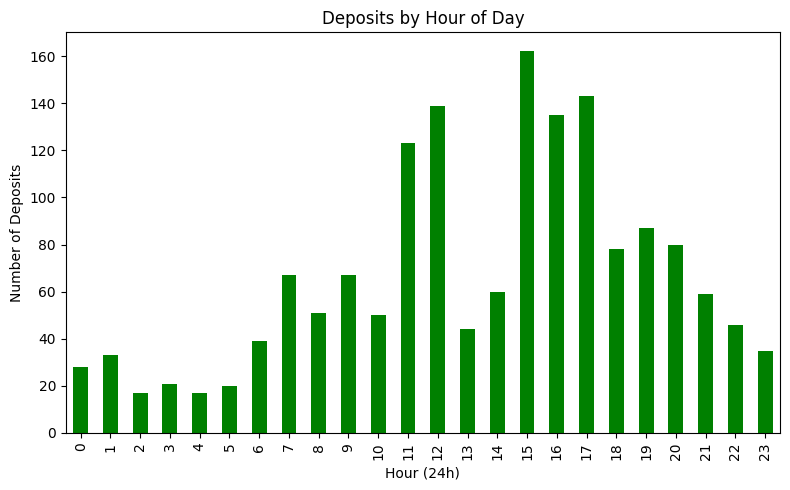

In [28]:
# Plot deposits by hour
plt.figure(figsize=(8,5))
hour_counts.plot(kind='bar', color='green')
plt.title("Deposits by Hour of Day")
plt.ylabel("Number of Deposits")
plt.xlabel("Hour (24h)")
plt.tight_layout()
plt.show()

## Fraud Detection Model

In [29]:
user_activity

,asset,amount,activity_type,timestamp,user_id
0,NGN,"131,062.00",withdrawal,2025-01-17 14:37:56.806446+00:00,561-1561-1521-1981-1101
1,NGN,"50,000.00",withdrawal,2025-01-17 14:37:56.818033+00:00,971-11001-1521-1571-1101
2,NGN,"131,062.00",deposit,2025-01-17 14:37:56.853225+00:00,481-11011-1521-1971-1100
3,NGN,"20,064.00",withdrawal,2025-01-17 17:05:18.201218+00:00,531-11001-1521-1571-198
4,NGN,"2,000.00",withdrawal,2025-01-17 14:38:22.555744+00:00,501-11021-1521-1561-154
...,...,...,...,...,...
4840,NGN,"5,100.00",withdrawal,2025-01-18 13:07:55.119388+00:00,531-11021-1521-1981-150
4841,NGN,"146,860.00",deposit,2025-03-12 17:55:24.702150+00:00,481-11011-1521-1971-1100
4842,NGN,"100,000.00",withdrawal,2025-03-12 21:58:33.931876+00:00,971-1991-1521-1571-148
4843,NGN,"20,000.00",withdrawal,2025-01-18 13:08:05.009124+00:00,541-11021-1521-1561-149


In [30]:
# --- Step 1: Aggregate user_activity features ---

def create_user_activity_features(user_activity):
    deposits = user_activity[user_activity["activity_type"] == "deposit"]
    withdrawals = user_activity[user_activity["activity_type"] == "withdrawal"]

    activity_features = user_activity.groupby("user_id").agg(
        num_deposits=("activity_type", lambda x: (x == "deposit").sum()),
        num_withdrawals=("activity_type", lambda x: (x == "withdrawal").sum()),
        total_deposit_amount=("amount", lambda x: user_activity.loc[x.index][user_activity.loc[x.index, "activity_type"] == "deposit"]["amount"].sum()),
        total_withdrawal_amount=("amount", lambda x: user_activity.loc[x.index][user_activity.loc[x.index, "activity_type"] == "withdrawal"]["amount"].sum()),
        first_deposit_time=("timestamp", lambda x: user_activity.loc[x.index][user_activity.loc[x.index, "activity_type"] == "deposit"]["timestamp"].min() if (user_activity.loc[x.index]["activity_type"] == "deposit").any() else pd.NaT),
        first_withdrawal_time=("timestamp", lambda x: user_activity.loc[x.index][user_activity.loc[x.index, "activity_type"] == "withdrawal"]["timestamp"].min() if (user_activity.loc[x.index]["activity_type"] == "withdrawal").any() else pd.NaT)
    ).reset_index()

    # Derived features
    activity_features["deposit_withdrawal_ratio"] = activity_features["num_withdrawals"] / (activity_features["num_deposits"] + 1)
    activity_features["withdrawal_to_deposit_ratio"] = activity_features["total_withdrawal_amount"] / (activity_features["total_deposit_amount"] + 1)

    activity_features["time_to_first_withdrawal"] = (
        activity_features["first_withdrawal_time"] - activity_features["first_deposit_time"]
    ).dt.total_seconds() / 3600  # convert to hours

    return activity_features

In [31]:
# --- Step 2: Aggregate trades features ---
def create_trade_features(trades):
    trade_features = trades.groupby("user_id").agg(
        total_trading_volume=("volume", "sum"),
        total_trading_amount=("amount", "sum"),
        num_trades=("pair", "count"),
        num_unique_assets_traded=("pair", pd.Series.nunique)
    ).reset_index()
    return trade_features

In [32]:
# --- Step 3: Merge features ---
def build_feature_table(user_activity, trades):
    user_feats = create_user_activity_features(user_activity)
    trade_feats = create_trade_features(trades)

    features = pd.merge(user_feats, trade_feats, on="user_id", how="left").fillna(0)

    # More derived features
    features["trading_vs_deposit_ratio"] = features["total_trading_volume"] / (features["total_deposit_amount"] + 1)
    features["trades_per_deposit"] = features["num_trades"] / (features["num_deposits"] + 1)

    return features

In [33]:
# --- Step 4: Rule-based labeling ---
def label_suspicious_users(features, withdrawal_threshold=0.8, trade_threshold=0.2, time_threshold=24):
    """
    Label suspicious users:
    - At least 1 deposit and 1 withdrawal
    - First withdrawal within `time_threshold` hours of first deposit
    - Trading volume <= trade_threshold * deposits
    - Withdrawals >= withdrawal_threshold * deposits
    """
    conditions = (
        (features["num_deposits"] > 0) &
        (features["num_withdrawals"] > 0) &
        (features["time_to_first_withdrawal"] <= time_threshold) &
        (features["trading_vs_deposit_ratio"] <= trade_threshold) &
        (features["withdrawal_to_deposit_ratio"] >= withdrawal_threshold)
    )

    features["is_fraud"] = conditions.astype(int)
    return features

In [34]:
features = build_feature_table(user_activity, trades)

In [35]:
# convert the features to a pandas dataframe
features_df = pd.DataFrame(features)

In [36]:
# see labelled features
labeled_features = label_suspicious_users(features)

In [37]:
labeled_features

,user_id,num_deposits,num_withdrawals,total_deposit_amount,total_withdrawal_amount,first_deposit_time,first_withdrawal_time,deposit_withdrawal_ratio,withdrawal_to_deposit_ratio,time_to_first_withdrawal,total_trading_volume,total_trading_amount,num_trades,num_unique_assets_traded,trading_vs_deposit_ratio,trades_per_deposit,is_fraud
0,1001-11001-1521-1561-154,3,20,"100,150.00","431,339.00",2025-01-17 17:38:26.189682+00:00,2025-01-17 14:56:53.191137+00:00,5.00,4.31,-2.69,0.00,"27,484.11",3,1,0.00,0.75,1
1,1001-11001-1521-1571-155,1,1,0.00,"32,888.00",2025-03-12 15:08:57.744625+00:00,2025-03-12 15:31:47.549399+00:00,0.50,"32,879.22",0.38,46.80,"71,703.21",1,1,46.79,0.50,0
2,1001-11001-1521-1971-1102,1,1,0.00,"40,300.00",2025-01-18 06:42:12.823378+00:00,2025-01-18 07:16:01.131864+00:00,0.50,"40,290.24",0.56,0.00,"70,009.30",1,1,0.00,0.50,1
3,1001-11001-1521-1971-156,0,1,0.00,"1,983.00",0,2025-04-01 12:43:29.495136+00:00,1.00,"1,983.00",0.00,0.31,"3,334.62",1,1,0.31,1.00,0
4,1001-11001-1521-1981-156,7,6,0.17,"93,089.00",2025-01-17 15:25:22.825389+00:00,2025-01-17 15:23:24.859884+00:00,0.75,"79,418.00",-0.03,0.02,"7,410.24",1,1,0.02,0.12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194,991-1991-1521-1971-1100,1,0,"30,150.00",0.00,2025-01-17 22:27:41.672146+00:00,0,0.00,0.00,0.00,0.00,"14,999.55",1,1,0.00,0.50,0
1195,991-1991-1521-1971-1101,1,0,"10,000.00",0.00,2025-03-12 16:59:18.184067+00:00,0,0.00,0.00,0.00,0.00,"36,519.00",2,2,0.00,1.00,0
1196,991-1991-1521-1981-1101,0,4,0.00,"59,000.00",0,2025-01-17 15:53:54.911309+00:00,4.00,"59,000.00",0.00,0.00,"134,194.52",1,1,0.00,1.00,0
1197,991-1991-1521-1981-1102,2,6,"440,300.00","98,200.00",2025-03-12 15:22:51.605819+00:00,2025-01-17 19:14:33.642192+00:00,2.00,0.22,"-1,292.14",0.00,"281,977.62",1,1,0.00,0.33,0


In [38]:
# rename the labeled features as df
df =  labeled_features

In [39]:
df.head()

,user_id,num_deposits,num_withdrawals,total_deposit_amount,total_withdrawal_amount,first_deposit_time,first_withdrawal_time,deposit_withdrawal_ratio,withdrawal_to_deposit_ratio,time_to_first_withdrawal,total_trading_volume,total_trading_amount,num_trades,num_unique_assets_traded,trading_vs_deposit_ratio,trades_per_deposit,is_fraud
0,1001-11001-1521-1561-154,3,20,"100,150.00","431,339.00",2025-01-17 17:38:26.189682+00:00,2025-01-17 14:56:53.191137+00:00,5.00,4.31,-2.69,0.00,"27,484.11",3,1,0.00,0.75,1
1,1001-11001-1521-1571-155,1,1,0.00,"32,888.00",2025-03-12 15:08:57.744625+00:00,2025-03-12 15:31:47.549399+00:00,0.50,"32,879.22",0.38,46.80,"71,703.21",1,1,46.79,0.50,0
2,1001-11001-1521-1971-1102,1,1,0.00,"40,300.00",2025-01-18 06:42:12.823378+00:00,2025-01-18 07:16:01.131864+00:00,0.50,"40,290.24",0.56,0.00,"70,009.30",1,1,0.00,0.50,1
3,1001-11001-1521-1971-156,0,1,0.00,"1,983.00",0,2025-04-01 12:43:29.495136+00:00,1.00,"1,983.00",0.00,0.31,"3,334.62",1,1,0.31,1.00,0
4,1001-11001-1521-1981-156,7,6,0.17,"93,089.00",2025-01-17 15:25:22.825389+00:00,2025-01-17 15:23:24.859884+00:00,0.75,"79,418.00",-0.03,0.02,"7,410.24",1,1,0.02,0.12,1


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199 entries, 0 to 1198
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   user_id                      1199 non-null   object 
 1   num_deposits                 1199 non-null   int64  
 2   num_withdrawals              1199 non-null   int64  
 3   total_deposit_amount         1199 non-null   float64
 4   total_withdrawal_amount      1199 non-null   float64
 5   first_deposit_time           1199 non-null   object 
 6   first_withdrawal_time        1199 non-null   object 
 7   deposit_withdrawal_ratio     1199 non-null   float64
 8   withdrawal_to_deposit_ratio  1199 non-null   float64
 9   time_to_first_withdrawal     1199 non-null   float64
 10  total_trading_volume         1199 non-null   float64
 11  total_trading_amount         1199 non-null   float64
 12  num_trades                   1199 non-null   int64  
 13  num_unique_assets_

In [41]:
# summary statistics of the dataframe
df.describe()

,num_deposits,num_withdrawals,total_deposit_amount,total_withdrawal_amount,deposit_withdrawal_ratio,withdrawal_to_deposit_ratio,time_to_first_withdrawal,total_trading_volume,total_trading_amount,num_trades,num_unique_assets_traded,trading_vs_deposit_ratio,trades_per_deposit,is_fraud
count,"1,199.00","1,199.00","1,199.00","1,199.00","1,199.00","1,199.00","1,199.00","1,199.00","1,199.00","1,199.00","1,199.00","1,199.00","1,199.00","1,199.00"
mean,1.34,2.71,"47,685.03","264,323.25",1.60,"147,934.71",-18.75,"66,126.37","288,449.81",1.94,1.21,"10,505.04",1.23,0.29
std,5.64,2.94,"678,538.15","1,056,070.23",1.76,"448,781.49",240.08,"1,727,751.99","698,835.69",1.72,0.60,"231,280.70",1.27,0.46
min,0.00,0.00,0.00,0.00,0.00,0.00,"-1,797.26",0.00,12.98,1.00,1.00,0.00,0.01,0.00
25%,0.00,1.00,0.00,"12,114.00",0.50,"1,636.67",0.00,0.00,"21,955.44",1.00,1.00,0.00,0.50,0.00
50%,1.00,2.00,0.00,"58,912.40",1.00,"24,243.11",0.00,0.06,"77,645.10",1.00,1.00,0.01,1.00,0.00
75%,1.00,3.00,8.37,"169,700.50",2.00,"102,600.00",0.25,30.01,"240,773.91",2.00,1.00,3.40,1.50,1.00
max,131.00,33.00,"14,734,641.00","19,591,459.00",20.00,"6,661,222.08","1,291.73","59,060,989.45","9,209,866.51",23.00,8.00,"7,527,402.50",18.00,1.00


In [42]:
# select numerical columns
numerical_cols = df.select_dtypes(include=['number']).columns

In [43]:
# check the skewness of the numerical columns
df[numerical_cols].skew()

,0
num_deposits,17.49
num_withdrawals,3.48
total_deposit_amount,17.79
total_withdrawal_amount,11.27
deposit_withdrawal_ratio,3.57
withdrawal_to_deposit_ratio,7.98
time_to_first_withdrawal,-2.22
total_trading_volume,33.38
total_trading_amount,6.51
num_trades,4.23


## Data Splitting and Feature Scaling

In [44]:
# drop Columns that do not feed the model like user_id and time stamps
drop_cols = [
    "user_id",
    "first_deposit_time",
    "first_withdrawal_time"
]

df_model = df.drop(columns=drop_cols)

In [45]:
# seperate features and target
X = df_model.drop(columns=["is_fraud"])
y = df_model["is_fraud"]

In [46]:
# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,      # important for fraud imbalance
    random_state=42
)

In [47]:
# log-transform excessively skewed features

# select the excessively skewed features
skewed_features = [
    "num_deposits",
    "total_deposit_amount",
    "total_withdrawal_amount",
    "total_trading_volume",
    "trading_vs_deposit_ratio"
]

# log transform both the train and test sets
for col in skewed_features:
    X_train[col] = np.log1p(X_train[col])
    X_test[col] = np.log1p(X_test[col])

In [48]:
# scale the numerical variables
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
#convert back to dataframe
feature_cols = X.columns.tolist()

X_train_scaled = pd.DataFrame(
    X_train_scaled,
    columns=feature_cols,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    X_test_scaled,
    columns=feature_cols,
    index=X_test.index
)

In [50]:
# save the feature artifacts to be reused in fast api for inference
import joblib

joblib.dump(scaler, "scaler.pkl")
joblib.dump(feature_cols, "feature_columns.pkl")

['feature_columns.pkl']

## Class Imbalance Handling and Supervised Model Training

## Logistic Regression

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, accuracy_score

log_reg = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    random_state=42
)

log_reg.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [52]:
# Evaluation
y_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]
y_pred_lr = (y_proba_lr >= 0.3).astype(int)

print("Logistic Regression")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))
print("PR-AUC:", average_precision_score(y_test, y_proba_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.85      0.92       170
           1       0.74      1.00      0.85        70

    accuracy                           0.90       240
   macro avg       0.87      0.93      0.88       240
weighted avg       0.92      0.90      0.90       240

ROC-AUC: 0.9772268907563025
PR-AUC: 0.9079821439960262
Accuracy: 0.8958333333333334


## Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=5,
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       min_samples_leaf=5, n_estimators=300, n_jobs=-1,
                       random_state=42)

In [54]:
# Evaluation
y_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]
y_pred_rf = (y_proba_rf >= 0.3).astype(int)

print("Random Forest")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("PR-AUC:", average_precision_score(y_test, y_proba_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       170
           1       0.93      1.00      0.97        70

    accuracy                           0.98       240
   macro avg       0.97      0.99      0.98       240
weighted avg       0.98      0.98      0.98       240

ROC-AUC: 0.9995798319327731
PR-AUC: 0.998964368136594
Accuracy: 0.9791666666666666


# XGBoost

In [55]:
from xgboost import XGBClassifier

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=42
)

xgb.fit(X_train_scaled, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, ...)

In [56]:
# Evaluation
y_proba_xgb = xgb.predict_proba(X_test_scaled)[:, 1]
y_pred_xgb = (y_proba_xgb >= 0.3).astype(int)

print("XGBoost")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))
print("PR-AUC:", average_precision_score(y_test, y_proba_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))

XGBoost
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       170
           1       0.96      1.00      0.98        70

    accuracy                           0.99       240
   macro avg       0.98      0.99      0.99       240
weighted avg       0.99      0.99      0.99       240

ROC-AUC: 1.0
PR-AUC: 0.9999999999999996
Accuracy: 0.9875


## MLP Classifier

In [57]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Convert to tensors
X_train_t = torch.tensor(X_train_scaled.values, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32)

X_test_t = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32)

train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=64,
    shuffle=True
)

# Model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

mlp = MLP(input_dim=13)

# Class imbalance handling
pos_weight = torch.tensor([(y_train == 0).sum() / (y_train == 1).sum()])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

# Training loop
mlp.train()
for epoch in range(20):
    epoch_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = mlp(xb).squeeze()
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 14.0817
Epoch 2, Loss: 12.4328
Epoch 3, Loss: 10.3522
Epoch 4, Loss: 8.0010
Epoch 5, Loss: 5.9952
Epoch 6, Loss: 4.6278
Epoch 7, Loss: 3.7675
Epoch 8, Loss: 3.2494
Epoch 9, Loss: 2.9203
Epoch 10, Loss: 2.6664
Epoch 11, Loss: 2.4528
Epoch 12, Loss: 2.2999
Epoch 13, Loss: 2.1485
Epoch 14, Loss: 2.0360
Epoch 15, Loss: 1.9238
Epoch 16, Loss: 1.8381
Epoch 17, Loss: 1.7477
Epoch 18, Loss: 1.6756
Epoch 19, Loss: 1.6233
Epoch 20, Loss: 1.5809


In [58]:
mlp.eval()
with torch.no_grad():
    logits = mlp(X_test_t).squeeze()
    y_proba_mlp = torch.sigmoid(logits).numpy()

y_pred_mlp = (y_proba_mlp >= 0.3).astype(int)

print("MLP")
print(classification_report(y_test, y_pred_mlp))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_mlp))
print("PR-AUC:", average_precision_score(y_test, y_proba_mlp))
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))


MLP
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       170
           1       0.89      1.00      0.94        70

    accuracy                           0.96       240
   macro avg       0.94      0.97      0.96       240
weighted avg       0.97      0.96      0.96       240

ROC-AUC: 0.9957142857142858
PR-AUC: 0.9894290987285088
Accuracy: 0.9625


In [59]:
# print the evaluation metrics collectively
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, f1_score, precision_score, recall_score

# Create a dictionary to hold metrics
metrics_dict = {
    "Model": [],
    "Accuracy": [],
    "ROC-AUC": [],
    "PR-AUC": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []
}

# Define a helper function to add metrics to the dictionary
def add_metrics(model_name, y_true, y_pred, y_proba):
    metrics_dict["Model"].append(model_name)
    metrics_dict["Accuracy"].append(f"{accuracy_score(y_true, y_pred):.4f}")
    metrics_dict["ROC-AUC"].append(f"{roc_auc_score(y_true, y_proba):.4f}")
    metrics_dict["PR-AUC"].append(f"{average_precision_score(y_true, y_proba):.4f}")
    metrics_dict["Precision"].append(f"{precision_score(y_true, y_pred):.4f}")
    metrics_dict["Recall"].append(f"{recall_score(y_true, y_pred):.4f}")
    metrics_dict["F1-Score"].append(f"{f1_score(y_true, y_pred):.4f}")

# Add metrics for each model
add_metrics("Logistic Regression", y_test, y_pred_lr, y_proba_lr)
add_metrics("Random Forest", y_test, y_pred_rf, y_proba_rf)
add_metrics("XGBoost", y_test, y_pred_xgb, y_proba_xgb)
add_metrics("MLP", y_test, y_pred_mlp, y_proba_mlp)

# Create a DataFrame for a side-by-side comparison
metrics_df = pd.DataFrame(metrics_dict)
metrics_df = metrics_df.set_index("Model")

# Display the comparison table
print(metrics_df)


                    Accuracy ROC-AUC  PR-AUC Precision  Recall F1-Score
Model                                                                  
Logistic Regression   0.8958  0.9772  0.9080    0.7368  1.0000   0.8485
Random Forest         0.9792  0.9996  0.9990    0.9333  1.0000   0.9655
XGBoost               0.9875  1.0000  1.0000    0.9589  1.0000   0.9790
MLP                   0.9625  0.9957  0.9894    0.8861  1.0000   0.9396


## Class Imbalance Handling and Unsupervised Model Trainingb

In [60]:
# --- Step 1: Imports ---
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [61]:
# --- Step 2: Prepare the data for unsupervised training ---
# Use only non-fraudulent samples for training
X_train_unsup = X_train_scaled[y_train == 0]
X_test_unsup = X_test_scaled
y_test_unsup = y_test.values  # keep labels for evaluation

In [62]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_unsup.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_unsup.values, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor), batch_size=32, shuffle=False)


In [63]:
# --- Step 3: Define Autoencoder ---
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon


In [64]:
# --- Step 4: Define VAE ---
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc21 = nn.Linear(32, latent_dim)  # mean
        self.fc22 = nn.Linear(32, latent_dim)  # logvar
        self.fc3 = nn.Linear(latent_dim, 32)
        self.fc4 = nn.Linear(32, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [65]:
# --- Step 5: Training function ---
def train_autoencoder(model, loader, epochs=50, lr=1e-3, vae=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in loader:
            x = batch[0]
            optimizer.zero_grad()
            if vae:
                recon, mu, logvar = model(x)
                recon_loss = criterion(recon, x)
                kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                loss = recon_loss + kld
            else:
                recon = model(x)
                loss = criterion(recon, x)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss / len(loader.dataset):.6f}")
    return model

In [66]:
# --- Step 6: Initialize and train Autoencoder ---
input_dim = X_train_tensor.shape[1]
ae_model = Autoencoder(input_dim)
ae_model = train_autoencoder(ae_model, train_loader, epochs=50)

Epoch 1/50, Loss: 1.032383
Epoch 2/50, Loss: 0.964791
Epoch 3/50, Loss: 0.865934
Epoch 4/50, Loss: 0.702331
Epoch 5/50, Loss: 0.532200
Epoch 6/50, Loss: 0.424247
Epoch 7/50, Loss: 0.352762
Epoch 8/50, Loss: 0.301758
Epoch 9/50, Loss: 0.264127
Epoch 10/50, Loss: 0.231447
Epoch 11/50, Loss: 0.204810
Epoch 12/50, Loss: 0.182426
Epoch 13/50, Loss: 0.163522
Epoch 14/50, Loss: 0.145986
Epoch 15/50, Loss: 0.133056
Epoch 16/50, Loss: 0.123007
Epoch 17/50, Loss: 0.114240
Epoch 18/50, Loss: 0.105445
Epoch 19/50, Loss: 0.098192
Epoch 20/50, Loss: 0.089845
Epoch 21/50, Loss: 0.084154
Epoch 22/50, Loss: 0.077754
Epoch 23/50, Loss: 0.072496
Epoch 24/50, Loss: 0.068933
Epoch 25/50, Loss: 0.064526
Epoch 26/50, Loss: 0.060311
Epoch 27/50, Loss: 0.060117
Epoch 28/50, Loss: 0.054411
Epoch 29/50, Loss: 0.050918
Epoch 30/50, Loss: 0.048149
Epoch 31/50, Loss: 0.045611
Epoch 32/50, Loss: 0.043597
Epoch 33/50, Loss: 0.042077
Epoch 34/50, Loss: 0.039934
Epoch 35/50, Loss: 0.037885
Epoch 36/50, Loss: 0.036419
E

Epoch 1/50, Loss: 1.111184
Epoch 2/50, Loss: 1.055148
Epoch 3/50, Loss: 1.031472
Epoch 4/50, Loss: 1.010043
Epoch 5/50, Loss: 0.995621
Epoch 6/50, Loss: 0.980173
Epoch 7/50, Loss: 0.946891
Epoch 8/50, Loss: 0.903618
Epoch 9/50, Loss: 0.874631
Epoch 10/50, Loss: 0.845326
Epoch 11/50, Loss: 0.826802
Epoch 12/50, Loss: 0.798502
Epoch 13/50, Loss: 0.790045
Epoch 14/50, Loss: 0.780058
Epoch 15/50, Loss: 0.757586
Epoch 16/50, Loss: 0.751956
Epoch 17/50, Loss: 0.736199
Epoch 18/50, Loss: 0.743135
Epoch 19/50, Loss: 0.722511
Epoch 20/50, Loss: 0.724250
Epoch 21/50, Loss: 0.706182
Epoch 22/50, Loss: 0.695270
Epoch 23/50, Loss: 0.700344
Epoch 24/50, Loss: 0.692532
Epoch 25/50, Loss: 0.672568
Epoch 26/50, Loss: 0.675357
Epoch 27/50, Loss: 0.674345
Epoch 28/50, Loss: 0.672908
Epoch 29/50, Loss: 0.670484
Epoch 30/50, Loss: 0.661212
Epoch 31/50, Loss: 0.667798
Epoch 32/50, Loss: 0.655291
Epoch 33/50, Loss: 0.660813
Epoch 34/50, Loss: 0.658429
Epoch 35/50, Loss: 0.648358
Epoch 36/50, Loss: 0.648197
E

In [67]:
# --- Step 7: Initialize and train VAE ---
vae_model = VAE(input_dim)
vae_model = train_autoencoder(vae_model, train_loader, epochs=50, vae=True)

Epoch 1/50, Loss: 1.104201
Epoch 2/50, Loss: 1.059993
Epoch 3/50, Loss: 1.030390
Epoch 4/50, Loss: 1.017806
Epoch 5/50, Loss: 0.983990
Epoch 6/50, Loss: 0.952823
Epoch 7/50, Loss: 0.918803
Epoch 8/50, Loss: 0.887448
Epoch 9/50, Loss: 0.842732
Epoch 10/50, Loss: 0.829946
Epoch 11/50, Loss: 0.804616
Epoch 12/50, Loss: 0.791692
Epoch 13/50, Loss: 0.775759
Epoch 14/50, Loss: 0.759699
Epoch 15/50, Loss: 0.731235
Epoch 16/50, Loss: 0.733644
Epoch 17/50, Loss: 0.731795
Epoch 18/50, Loss: 0.713363
Epoch 19/50, Loss: 0.708211
Epoch 20/50, Loss: 0.699622
Epoch 21/50, Loss: 0.691213
Epoch 22/50, Loss: 0.696611
Epoch 23/50, Loss: 0.684247
Epoch 24/50, Loss: 0.673611
Epoch 25/50, Loss: 0.654931
Epoch 26/50, Loss: 0.664440
Epoch 27/50, Loss: 0.663268
Epoch 28/50, Loss: 0.654894
Epoch 29/50, Loss: 0.641429
Epoch 30/50, Loss: 0.640402
Epoch 31/50, Loss: 0.647263
Epoch 32/50, Loss: 0.651169
Epoch 33/50, Loss: 0.644037
Epoch 34/50, Loss: 0.650398
Epoch 35/50, Loss: 0.644546
Epoch 36/50, Loss: 0.638532
E

In [68]:
# --- Step 8: Compute reconstruction errors ---
def get_reconstruction_errors(model, loader, vae=False):
    model.eval()
    errors = []
    with torch.no_grad():
        for batch in loader:
            x = batch[0]
            if vae:
                recon, _, _ = model(x)
            else:
                recon = model(x)
            batch_error = torch.mean((x - recon) ** 2, dim=1)
            errors.append(batch_error)
    return torch.cat(errors).numpy()

ae_errors = get_reconstruction_errors(ae_model, test_loader)
vae_errors = get_reconstruction_errors(vae_model, test_loader, vae=True)

In [69]:
# --- Step 9: Determine threshold using training reconstruction errors ---
train_errors_ae = get_reconstruction_errors(ae_model, DataLoader(TensorDataset(X_train_tensor), batch_size=32))
train_errors_vae = get_reconstruction_errors(vae_model, DataLoader(TensorDataset(X_train_tensor), batch_size=32), vae=True)

threshold_ae = np.percentile(train_errors_ae, 95)
threshold_vae = np.percentile(train_errors_vae, 95)

In [70]:
# --- Step 10: Predict anomalies ---
y_pred_ae = (ae_errors > threshold_ae).astype(int)
y_pred_vae = (vae_errors > threshold_vae).astype(int)

In [71]:
# --- Step 11: Evaluation ---
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, accuracy_score

ae_metrics = {
    "Model": "Autoencoder",
    "Accuracy": accuracy_score(y_test_unsup, y_pred_ae),
    "ROC-AUC": roc_auc_score(y_test_unsup, ae_errors),
    "PR-AUC": average_precision_score(y_test_unsup, ae_errors)
}

In [72]:
vae_metrics = {
    "Model": "VAE",
    "Accuracy": accuracy_score(y_test_unsup, y_pred_vae),
    "ROC-AUC": roc_auc_score(y_test_unsup, vae_errors),
    "PR-AUC": average_precision_score(y_test_unsup, vae_errors)
}

In [73]:
print("--- Autoencoder ---")
print(classification_report(y_test_unsup, y_pred_ae))
print("--- VAE ---")
print(classification_report(y_test_unsup, y_pred_vae))

--- Autoencoder ---
              precision    recall  f1-score   support

           0       0.74      0.90      0.81       170
           1       0.48      0.23      0.31        70

    accuracy                           0.70       240
   macro avg       0.61      0.56      0.56       240
weighted avg       0.66      0.70      0.67       240

--- VAE ---
              precision    recall  f1-score   support

           0       0.73      0.94      0.82       170
           1       0.48      0.14      0.22        70

    accuracy                           0.70       240
   macro avg       0.60      0.54      0.52       240
weighted avg       0.65      0.70      0.64       240



In [74]:
# --- Step 12: Compare unsupervised models ---
unsup_metrics = pd.DataFrame([ae_metrics, vae_metrics])
print("\n--- Unsupervised Model Comparison ---")
print(unsup_metrics)


--- Unsupervised Model Comparison ---
         Model  Accuracy  ROC-AUC  PR-AUC
0  Autoencoder      0.70     0.78    0.51
1          VAE      0.70     0.62    0.39


## Save all the Models

In [75]:
import joblib
joblib.dump(log_reg, 'lr_model.pkl')
joblib.dump(rf, 'rf_model.pkl')
joblib.dump(xgb, 'xgb_model.pkl')
joblib.dump(mlp, 'mlp_model.pkl')
joblib.dump(ae_model, 'ae_model.pkl')
joblib.dump(vae_model, 'vae_model.pkl')


['vae_model.pkl']

## Model Ensembling

In [76]:
# Use the trained models to predict probabilities
lr_probs = log_reg.predict_proba(X_test_scaled)[:,1]
rf_probs = rf.predict_proba(X_test_scaled)[:,1]
xgb_probs = xgb.predict_proba(X_test_scaled)[:,1]

## Pytorch Models

## MLP

In [77]:
mlp.eval()
with torch.no_grad():
    X_tensor = torch.tensor(
        X_test_scaled.values,   # or .to_numpy()
        dtype=torch.float32
    )
    logits = mlp(X_tensor)
    mlp_probs = torch.sigmoid(logits).squeeze().numpy()


4.9695228e-17 0.9995696


In [ ]:
mlp_preds = (mlp_probs >= 0.5).astype(int)

## Autoeencoder

In [78]:
ae_model.eval()

with torch.no_grad():
    X_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
    X_recon = ae_model(X_tensor)

ae_errors = torch.mean((X_tensor - X_recon) ** 2, dim=1).cpu().numpy()

In [79]:
from sklearn.preprocessing import MinMaxScaler

# Training errors (fit scaler here)
ae_model.eval()
with torch.no_grad():
    X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
    X_train_recon = ae_model(X_train_tensor)

ae_train_errors = torch.mean(
    (X_train_tensor - X_train_recon) ** 2, dim=1
).cpu().numpy()

# Normalize
ae_scaler = MinMaxScaler()
ae_scaler.fit(ae_train_errors.reshape(-1, 1))

# Test probabilities
ae_probs = ae_scaler.transform(ae_errors.reshape(-1, 1)).flatten()

## Variational Autoencoder

In [80]:
vae_model.eval()

with torch.no_grad():
    X_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
    recon, mu, logvar = vae_model(X_tensor)

recon_error = torch.mean((X_tensor - recon) ** 2, dim=1)
kl_div = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp(), dim=1)

vae_errors = (recon_error + kl_div).cpu().numpy()

In [81]:
vae_model.eval()
with torch.no_grad():
    X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
    recon_train, mu_train, logvar_train = vae_model(X_train_tensor)

recon_train_error = torch.mean((X_train_tensor - recon_train) ** 2, dim=1)
kl_train = -0.5 * torch.sum(
    1 + logvar_train - mu_train**2 - logvar_train.exp(), dim=1
)

vae_train_errors = (recon_train_error + kl_train).cpu().numpy()

vae_scaler = MinMaxScaler()
vae_scaler.fit(vae_train_errors.reshape(-1, 1))

vae_probs = vae_scaler.transform(vae_errors.reshape(-1, 1)).flatten()

In [83]:
print(mlp_probs.min(), mlp_probs.max())
print(ae_probs.min(), ae_probs.max())
print(vae_probs.min(), vae_probs.max())

8.3524086e-17 0.9998053
0.00012382877 1.1859257
-0.0010695904 0.83419967


## Clipping

In [84]:
mlp_probs = np.clip(mlp_probs, 0.0, 1.0)
ae_probs = np.clip(ae_probs, 0.0, 1.0)
vae_probs = np.clip(vae_probs, 0.0, 1.0)

In [85]:
print(mlp_probs.min(), mlp_probs.max())
print(ae_probs.min(), ae_probs.max())
print(vae_probs.min(), vae_probs.max())


8.3524086e-17 0.9998053
0.00012382877 1.0
0.0 0.83419967


##

In [86]:
#  Combine all probabilities ---
all_probs = np.vstack([lr_probs, rf_probs, xgb_probs, mlp_probs, ae_probs, vae_probs]).T

# --- Step 3: Ensemble predictions ---
# Soft voting: average all probabilities
ensemble_probs = np.mean(all_probs, axis=1)
ensemble_preds = (ensemble_probs >= 0.5).astype(int)

# --- Step 4: Evaluate ensemble ---
print("Ensemble Evaluation Metrics")
print("----------------------------")
print(classification_report(y_test, ensemble_preds, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, ensemble_probs))
print("F1 Score:", f1_score(y_test, ensemble_preds))
print("Precision:", precision_score(y_test, ensemble_preds))
print("Recall:", recall_score(y_test, ensemble_preds))


Ensemble Evaluation Metrics
----------------------------
              precision    recall  f1-score   support

           0     0.9770    1.0000    0.9884       170
           1     1.0000    0.9429    0.9706        70

    accuracy                         0.9833       240
   macro avg     0.9885    0.9714    0.9795       240
weighted avg     0.9837    0.9833    0.9832       240

ROC-AUC: 1.0
F1 Score: 0.9705882352941176
Precision: 1.0
Recall: 0.9428571428571428


In [87]:
# --- Optional: Create a DataFrame for side-by-side comparison ---
metrics = {
    "Model": ["Logistic Regression", "Random Forest", "XGBoost", "MLP", "Autoencoder", "VAE", "Ensemble"],
    "ROC-AUC": [
        roc_auc_score(y_test, lr_probs),
        roc_auc_score(y_test, rf_probs),
        roc_auc_score(y_test, xgb_probs),
        roc_auc_score(y_test, mlp_probs),
        roc_auc_score(y_test, ae_probs),
        roc_auc_score(y_test, vae_probs),
        roc_auc_score(y_test, ensemble_probs)
    ],
    "F1 Score": [
        f1_score(y_test, (lr_probs >= 0.5).astype(int)),
        f1_score(y_test, (rf_probs >= 0.5).astype(int)),
        f1_score(y_test, (xgb_probs >= 0.5).astype(int)),
        f1_score(y_test, (mlp_probs >= 0.5).astype(int)),
        f1_score(y_test, (ae_probs >= 0.5).astype(int)),
        f1_score(y_test, (vae_probs >= 0.5).astype(int)),
        f1_score(y_test, ensemble_preds)
    ]
}

metrics_df = pd.DataFrame(metrics)
print("\nSide-by-side comparison:")
print(metrics_df)



Side-by-side comparison:
                 Model  ROC-AUC  F1 Score
0  Logistic Regression     0.98      0.87
1        Random Forest     1.00      0.98
2              XGBoost     1.00      0.99
3                  MLP     1.00      0.94
4          Autoencoder     0.78      0.03
5                  VAE     0.35      0.03
6             Ensemble     1.00      0.97
